# Projet phylogénétique
Théophile Sanchez (theophile.sanchez@inria.fr) - Sarah Cohen Boulakia

------

## Introduction

Au cours de ce projet, vous étudierez trois espèces disparues de félins qui vivaient autrefois sur le continent Américain. Ces trois espèces, le _smilodon_ (tigre à dents de sabre), l'_homotherium_ (_scimitar toothed tigers_) et _M. trumani_ (guépard américain) se sont éteintes il y a environ 13 000 ans, à la fin de la dernière période glaciaire. Des séquences ADN partielles de la protéine cytochrome b de ces espèces ont pu être séquencées et vont vous permettre de retrouver les liens de parentés entre ces espèces et des espèces de félins contemporaines : le chat domestique, le lion, le léopard, le tigre, le puma, le guépard et les chats sauvages africains, chinois et européens. Sont aussi présent dans le jeu de donnée des séquences issues d'espèces extérieures aux félins.

Afin de reconstruire l'arbre phylogénétique de ces espèces, vous utiliserez une méthode basée sur le calcul des distances évolutives entre les séquences ADN des protéines. Sachez qu'une démarche similaire peut-être appliquée aux séquences d'acides aminés.

Les différentes étapes qui vous permetterons de construire l'arbre sont détaillées dans ce notebook. Vous devrez implémenter les algorithmes en Python et répondre aux questions dans les cellules prévues.

Quelques conseils :
- Utiliser au maximum les fonctions présentes dans les packages de python (sauf si il vous est explicitement demandé de les réimplémenter). Si un problème vous paraît courant, il existe surement déjà une fonction pour le résoudre. Pour ce projet vous serez limité aux packages de base, à Numpy et ETE (seulement pour l'affichage des arbres).
- Si une partie de votre code ne vous semble pas très explicite, ajoutez des commentaires pour l'expliquer. Une personne qui lit votre code doit pouvoir comprendre son fonctionnement facilement.
- N'hésitez pas à chercher dans la documentation et sur internet. Cependant, faites attention au plagiat !

Le projet est à rendre **en binôme** par mail avant le **22/04**. Vous regrouperez votre notebook et les fichiers nécessaires à son fonctionnement dans une archive portant vos noms et prénoms.

------
## Importation des séquences

Le format FASTA permet de stocker plusieurs séquences (ADN, ARN ou peptidiques) dans un fichier. Les séquences que vous allez étudier ont été regroupées dans le fichier `cat_dna.fasta`.

**Exercice 1 :** Écriver une fonction permettant d'importer un fichier au format fasta et de le stocker dans un dictionnaire. Les clés seront les noms des séquences et les valeurs du dictionnaire seront les séquences d'adn.

In [1]:
import re

def lire_fasta(filename):

    # Regex des clés et des séquences
    key = re.compile("[>].*")
    sequence = re.compile("[ACTG]+")

    # Dictionnaire contenant les couples clés séquences
    dic = {}
    
    with open(filename, "r") as file:
        # Etat de recherché d'une clé
        attente_cle = 0
        # Etat de lecture d'une séquence ADN
        lecture_sequence = 1
        
        # Etat initial = recherche d'une clé
        mode = attente_cle
        
        # On récupère la première ligne
        line = file.readline()

        # Valeurs courantes du couple clé séquence
        current_key = ""
        current_seq = ""

        # La séquence étant sur plusieurs lignes, on la stocke dans un buffer temporaire
        tmp_seq = []

        # Tant qu'il reste des lignes à lire
        while (line != ''):
            
            # Si on recherche une clé
            if mode == attente_cle:
                
                # La ligne est-elle une clé ?
                if key.match(line):
                    
                    # On passe en lecture de séquence
                    mode = lecture_sequence
                    # On stocke la clé
                    current_key = line[1:].strip()
                    
            # Sinon on recherche une lecture
            else:
                
                # Si la ligne est une partie de séquence ADN
                if sequence.match(line):
                    
                    # On stocke le bout d'ADN dans le buffer
                    tmp_seq.append(line.strip())
                    
                # Sinon on a fini de lire la séquence
                else:
                    
                    # On stocke tout l'ADN
                    current_seq = "".join(tmp_seq)
                    # On passe en recherche de clé
                    mode = attente_cle
                    # On stocke le couple clé séquence dans le dictionnaire
                    dic[current_key] = current_seq
                    # On vide le buffer d'ADN
                    tmp_seq = []

            # On relit une ligne
            line = file.readline()

        # Dictionnaire des séquences
        return dic

------
## Alignement des séquences

La méthode que vous utiliserez pour calculer l'arbre phylogénétique nécessite de calculer la distance évolutive entre les séquences. Avant de pouvoir les calculer, il faut d'abord aligner les séquences en considérant trois types de mutations :
- les substitutions (un nucléotide est remplacé par un autre)
- les insertions
- les délétions
Par exemple, les séquences "ACTCCTGA" et "ATCTCGTGA" ont plusieurs alignements possibles : 

$A_1$ :
```
-ACTCCTGA
ATCTCGTGA
```

$A_2$ :
```
A-CTCCTGA
ATCTCGTGA
```

$A_3$ :
```
AC-TCCTGA
ATCTCGTGA
```
.

.

.

Le "-" désigne un *gap*, c'est à dire un "trou" dans l'alignement qui a été causé par une insertion ou une déletion. On regroupe ces deux types de mutations sous le terme indel.

Ces alignements correspondent à une multitude d'histoires phylogénétiques différentes. Pour sélectionner le meilleur alignement il faut donc introduire l'hypothèse du maximum de parcimonie qui privilégie l'histoire phylogénétique qui implique le moins d'hypothèses et donc, le moins de changements évolutifs. Par exemple, parmis les trois alignements ci-dessus on preferera l'alignement 2 car il correspond au scénario avec le moins de mutations:
- l'alignement 1 implique au minimum 1 indel et 3 substitutions
- l'alignement 2 implique au minimum 1 indel et 2 substitutions
- l'alignement 3 implique au minimum 1 indel et 3 substitutions

On peut maintenant définir un score d'identité que l'on va augmenter de 1 lorsque qu'il n'y pas eu de mutation et ainsi obtenir la matrice suivante :

|   &nbsp;   | A | C | G | T | - |
|   -   | - | - | - | - | - |
| **A** | 1 | 0 | 0 | 0 | 0 |
| **C** | 0 | 1 | 0 | 0 | 0 |
| **G** | 0 | 0 | 1 | 0 | 0 |
| **T** | 0 | 0 | 0 | 1 | 0 |
| **-** | 0 | 0 | 0 | 0 | 0 |

Cette matrice correspond au modèle d'évolution de l'ADN défini par Jukes et Cantor qui fait l'hypothèse d'un taux de mutation équivalent pour chacun des nucléotides. Cependant, en réalité ces taux ne sont pas les mêmes partout, on sait par exemple que le taux de transition (substitution A$\leftrightarrow$G ou C$\leftrightarrow$T) est différent du taux de transversions (substitution A$\leftrightarrow$T, C$\leftrightarrow$G, C$\leftrightarrow$A ou G$\leftrightarrow$T) et que d'autres facteurs devrait être pris en compte comme la fréquence du nucléotide dans l'ADN. [C'est pour cette raison qu'il existe beaucoup de modèles différents d'écrivant l'évolution de l'ADN.](https://en.wikipedia.org/wiki/Models_of_DNA_evolution) Dans la suite de ce projet nous utiliserons la matrice de similarité $S$ suivante : 

|   &nbsp;   | A  | C  | G  | T  | -  |
|   -   | -  | -  | -  | -  | -  |
| **A** | 10 | -1 | -3 | -4 | -5 |
| **C** | -1 | 7  | -5 | -3 | -5 |
| **G** | -3 | -5 | 9  | 0  | -5 |
| **T** | -4 | -3 | 0  | 8  | -5 |
| **-** | -5 | -5 | -5 | -5 | -5 |

**Exercice 2 :** Écriver la fonction permettant de calculer le score entre deux alignements avec la matrice de similarité précédente puis afficher le score des trois alignements $A_1$, $A_2$ et $A_3$. La classe permettant d'importer une matrice et de calculer le score entre deux lettres vous est déjà fournie, la matrice de similarité est stockée dans le fichier `dna_matrix` :


In [3]:
import numpy as np


class SimilarityMatrix:
    def __init__(self, filename):
        with open(filename) as f:
            self.letters = f.readline().split()
            self.dic = {"A" : 0, "C" : 1, "G" : 2, "T" : 3, "-" : 4}
            self.values = np.loadtxt(filename, skiprows=1, usecols=range(1, len(self.letters) + 1))
        
    def score(self, letter1, letter2): # return the similarity score between letter1 and letter2
        return self.values[self.dic[letter1]][self.dic[letter2]]
    
# Example
similarity_matrix = SimilarityMatrix('dna_matrix')
print('Score between G and C:', similarity_matrix.score('G', 'C'))
print('Score between A and a gap:', similarity_matrix.score('-', 'A'))

Score between G and C: -5.0
Score between A and a gap: -5.0


In [19]:
def score_alignement(seq1, seq2):
    m = SimilarityMatrix('dna_matrix')
    
    if len(seq1) != len(seq2):
        raise Exception("Séquences pas de même longueur")
    
    sum = 0
    for let1, let2 in zip(seq1, seq2):
        sum += m.score(let1, let2)
    return sum

A1 = ("-ACTCCTGA", "ATCTCGTGA")
A2 = ("A-CTCCTGA", "ATCTCGTGA")
A3 = ("AC-TCCTGA", "ATCTCGTGA")
print("Score A1 : {}".format(score_alignement(*A1)))
print("Score A2 : {}".format(score_alignement(*A2)))
print("Score A3 : {}".format(score_alignement(*A3)))

Score A1 : 35.0
Score A2 : 49.0
Score A3 : 39.0


------
### Algorithme de Needleman-Wunsch

Maintenant que vous avez vu ce qu'est une matrice de similarité et comment calculer le score de similarité d'un alignement, vous allez devoir implémenter un algorithme permettant de trouver le meilleur alignement global entre deux séquences. Avec deux séquences à aligner de taille $n$ et $m$, la première étape consiste à initialiser deux matrices de taille $n \times m$. La première est la matrice de score $M$ et la seconde sera la matrice de *traceback* $T$. 

Par exemple, avec la matrice $S$ et les séquences $A =$ "ACTCCTGA" et $B =$ "ATCTCGTGA", on initialise $M$ comme si l'on ajoutait des *gaps* partout :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | 0 |-5 |-10|-15|-20|-25|-30|-35|-40|-45|
| **A** |-5 | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-10| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-15| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-20| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-25| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-30| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** |-45| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** |-40| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||

Puis on initialise $T$ :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||


Il faut ensuite remplir la matrice $M$ en suivant la formule $M_{ij} = \max(M_{i-1j-1} + s(A_i, B_j), M_{ij-1} + s(A_i, gap), M_{i-1j} + s(B_j,gap) )$ avec $i \in {2, \dots, n}$, $j \in {2, \dots, m}$ et la fonction $s$ qui calcule le score de similarité entre deux nucléotides. Pour chaque case de $T$ on remplie par :
- 'd' (*diagonal*) si $M_{ij}$ a été calculé en utilisant la diagonale $M_{i-1j-1}$,
- 'l' (*left*) si $M_{ij}$ a été calculé en utilisant la case de gauche $M_{ij-1}$,
- 'u' (*up*) si $M_{ij}$ a été calculé en utilisant la case du haut $M_{i-1j}$.

On obtient alors les matrices suivantes $M$ et $T$ : 

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** |  0| -5|-10|-15|-20|-25|-30|-35|-40|-45|
| **A** | -5| 10|  5|  0| -5|-10|-15|-20|-25|-30|
| **C** |-10|  5|  7| 12|  7|  2| -3| -8|-13|-18|
| **T** |-15|  0| 13|  8| 20| 15| 10|  5|  0| -5|
| **C** |-20| -5|  8| 20| 15| 27| 22| 17| 12|  7|
| **C** |-25|-10|  3| 15| 17| 22| 22| 19| 14| 11|
| **T** |-30|-15| -2| 10| 23| 18| 22| 30| 25| 20|
| **G** |-35|-20| -7|  5| 18| 18| 27| 25| 39| 34|
| **A** |-40|-25|-12|  0| 13| 17| 22| 23| 34| 49|

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | d | l | l | l | l | l | l | l | d |
| **C** | u | u | d | d | l | d | l | l | l | l |
| **T** | u | u | d | l | d | l | l | d | l | l |
| **C** | u | u | u | d | l | d | l | l | l | l |
| **C** | u | u | u | d | d | d | d | d | l | d |
| **T** | u | u | d | u | d | l | d | d | l | l |
| **G** | u | u | u | u | u | d | d | u | d | l |
| **A** | u | d | u | u | u | d | u | d | u | d |

Il suffit maintenant de regarder le dernier élément $M_{nm} = 49$ pour avoir le score de l'alignement. Pour avoir l'alignement lui-même, il faut partir de $T_{nm}$ et remonter la "trace" jusqu'à arriver au 'o'. Un 'd' correspond à un *match* entre les deux séquences, 'l' à un *gap* dans la séquence $A$ et 'u' à un *gap* dans la séquence $B$. En revenant à l'exemple précédent on obtient la trace suivante :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | &nbsp; | d | l | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; |
| **G** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d |

Elle correspond à l'alignement :
```
A-CTCCTGA
ATCTCGTGA
```

**Exercice 3 :** Implémenter l'algorithme de Needlman et Wunsch. Il prendra en paramètre deux séquences et une matrice de similarité et retournera leur alignement. Tester le avec les séquences "ACTCCTGA" et "ATCTCGTGA".

In [6]:
D = 0
L = 1
U = 2
O = -1

def init_gap(matrix):
    matrix[0] = np.array([-i * 5 for i in range(0, np.size(matrix[0]))])
    matrix[:,0] = np.array([-i * 5 for i in range(0, np.size(matrix[:,0]))])

def init_t(T):
    global L, D, U, O
    
    T[0] = np.array([L]*np.size(T[0]))
    T[:,0] = np.array([U]*np.size(T[:,0]))
    T[0,0] = O
    
def formule_needleman(i, j, M, seq1, seq2):
    global similarity_matrix
    global L, D, U
    s = similarity_matrix.score
    
    val1 = M[i-1, j-1] + s(seq1[i - 1], seq2[j - 1])
    
    val2 = M[i, j-1] + s(seq1[i - 1], '-')
    
    val3 = M[i-1, j] + s(seq2[j - 1], '-')
    
    if val1 > val2:
        if val1 > val3:
            return val1, 0
        else:
            return val3, 2
    else:
        if val2 > val3:
            return val2, 1
        else:
            return val2, 2

def backtrack(T):
    global L, D, U, O
    
    i, j = np.size(T[:, 0]) - 1, np.size(T[0]) - 1
    track = []
    
    while T[i, j] != O:
        track.append(T[i, j])
        if T[i, j] == D:
            i, j = i-1, j-1
        elif T[i, j] == L:
            j -= 1
        elif T[i, j] == U:
            i -= 1
        else:
            print("bug")
    
    return track[::-1]

def alignement_from_backtrack(seq1, seq2, backtrack):
    global D, L, U
    res1, res2 = [], []
    
    c1, c2 = 0, 0
    for i, deplacement in enumerate(backtrack):
        if deplacement == D:
            res1.append(seq1[c1])
            res2.append(seq2[c2])
            c1 += 1
            c2 += 1
        elif deplacement == L:
            res1.append('-')
            res2.append(seq2[c2])
            c2 += 1
        else:
            res1.append(seq1[c1])
            res2.append('-')
            c1 += 1
            
    return "".join(res1), "".join(res2)
            

def needleman_wunsch(seq1, seq2):
    global L, D, U, O
    
    M = np.zeros(shape=(len(seq1) + 1, len(seq2) + 1))
    init_gap(M)
    
    T = np.full((len(seq1) + 1, len(seq2) + 1), O)
    init_t(T)
    
    for i in range(1, len(seq1) + 1):
        for j in range(1, len(seq2) + 1):
            M[i, j], T[i, j] = formule_needleman(i, j, M, seq1, seq2)
    
    backt = backtrack(T)
    
    alignement = alignement_from_backtrack(seq1, seq2, backt)
    
    return alignement

seq1 = "ACTCCTGA"
seq2 = "ATCTCGTGA"
print(needleman_wunsch(seq1, seq2))

('A-CTCCTGA', 'ATCTCGTGA')


----
## Matrice de distance

Dans le cas de séquences très proches, on estime que la distance évolutive réelle entre les séquences est proche de la p-distance qui est simplement le nombre de substitution dans l'alignement sur le nombre total de nucléotide. Pour simplifier, on ignore les positions alignées à des gaps. On applique ensuite la correction de Jukes-Cantor afin de prendre en compte le phénomène de saturation (un même site peut muter plusieurs fois au cours du temps). Sa formule est $-(\frac{3}{4})\ln(1-(\frac{4}{3})\times \textit{p-distance})$.

**Exercice 4 :** Implémenter la fonction retournant la matrice de distance à partir d'un dictionnaire de séquences. 

In [7]:
def pdistance(al1, al2):
    """ Renvoie le rapport du nombre de substitutions sur le nombre de nucléotides
    """
    # Nombre de substitutions
    nb = 0
    
    # Pour tous les éléments des séquences
    for e1, e2 in zip(al1, al2):
        # On incrémente s'il y a substitution
        nb += 1 if (e1 != e2 and e1 != '-' and e2 != '-') else 0
        
    # On renvoie le rapport
    return nb / len(al1)

def juke_cantor(pdistance):
    """ Applique la formule de juke cantor sur la pdistance donnée
    """
    return -(3/4) * np.log(1 - (4/3) * pdistance)

def matrice_distance(dic):
    keys = list(dic.keys())
    matrix = np.zeros((len(keys), len(keys)), dtype=np.float64)
    print(type(matrix[0,0]))
    
    for i, key1 in enumerate(keys):
        for j in range(i, len(keys)):
            key2 = keys[j]
            al1, al2 = needleman_wunsch(dic[key1], dic[key2])
            pdist = pdistance(al1, al2)
            dist = juke_cantor(pdist)
            matrix[j, i] = float(dist)
            
        print("{}/{}".format(i, len(keys)))
    
    return matrix

def save_matrix(filename, matrix):
    np.save(filename, matrix)

    
fasta = "cat_dna.fasta"
dic = lire_fasta(fasta)
chiffre_vers_nom = list(dic.keys())

file = "distmatrix.npy"
m = None
load_if_exists = False
save_matrice = True

if load_if_exists and os.path.isfile(file):
    m = np.load(file + ".npy")
else:
    m = matrice_distance(dic)
    
print("Matrice de distance :")
print(m)

if save_matrice:
    save_matrix(file, m)
    print("Matrice sauvegardée dans {}.npy".format(file))

<class 'numpy.float64'>
0/18
1/18
2/18
3/18
4/18
5/18
6/18
7/18
8/18
9/18
10/18
11/18
12/18
13/18
14/18
15/18
16/18
17/18
Matrice de distance :
[[-0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.14708616 -0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.12069778  0.09725837 -0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.01382528  0.13319026  0.1136315  -0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.11405036  0.11803443  0

------
## Construction d'un arbre avec UPGMA

Grâce aux mesures de distances entre les séquences, on peut maintenant de construire l'arbre phylogénétique des globines. Vous allez devoir pour cela implémenter l'algorithme UPGMA (*unweighted pair group method with arithmetic mean*) qui, malgré son nom compliqué, est l'une des méthodes les plus simples pour la construction d'arbre.

### Le format Newick

Le format Newick est l'un des formats utilisé en phylogénie pour représenter un arbre sous la forme d'une chaine de caractère. Le principe est simple, les groupes ayant la même racine sont écrit entre parenthèses et séparés par des virgules. Un groupe peut être soit une feuille de l'arbre (dans notre cas une séquence), soit un autre groupe. La longueur de la branche de chaque groupe est écrite après un double point et l'arbre est terminé par un point virgule. Pour afficher l'arbre on peut utiliser les fonction du package ETE : 

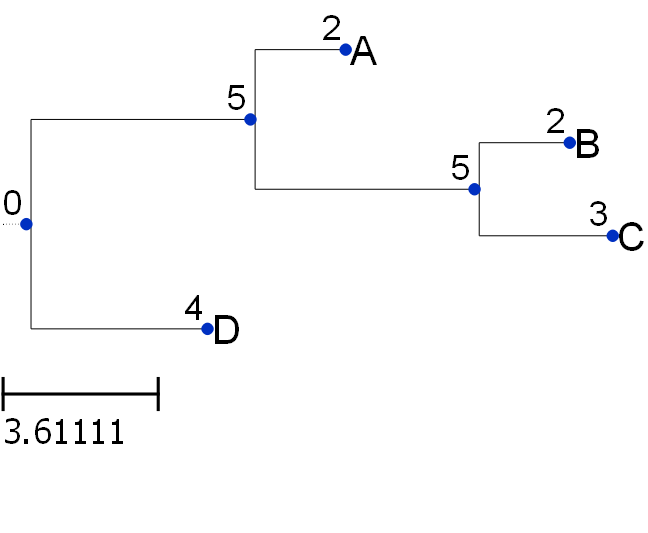

In [16]:
from ete3 import Tree, TreeStyle

newick_tree = '((A:2,(B:2,C:3):5):5,D:4);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 5 :** Reécriver l'arbre suivant au format Newick puis afficher-le. Les nombres correspondent aux longueurs des branches :
![](tree.png)

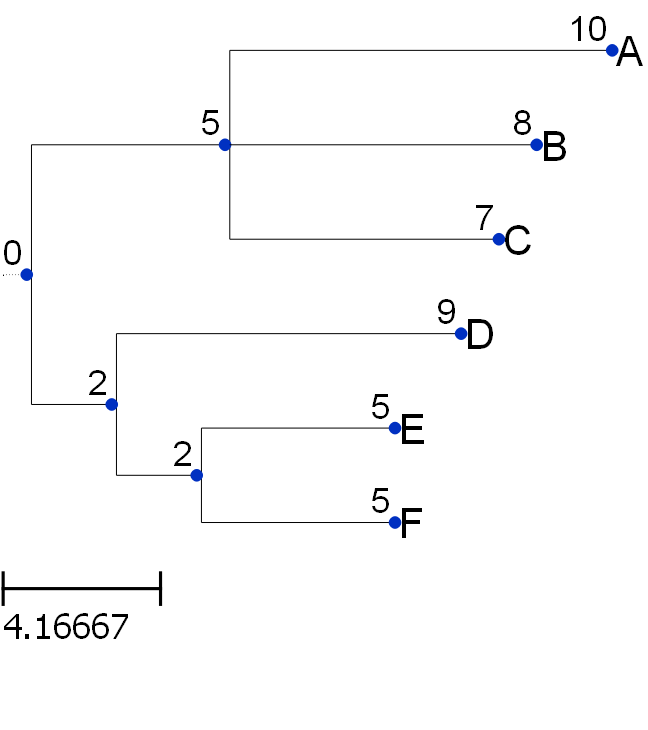

In [224]:
newick_tree = '((A : 10, B : 8, C : 7) : 5, (D : 9, (E : 5, F : 5) : 2) : 2);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 6 :** Expliquer la relation de parenté entre $A$, $B$ et $C$ ? Qu'est ce qui pourrait expliquer ce type d'embranchement dans un arbre ? Donner une réponse détaillée.

Réponse : A, B et C ont le même plus proche ancêtre commun.
Une telle spéciation peut apparaître si l'espèce initiale se separe en trois populations isolées.

### UPGMA

L'algorithme UPGMA se base sur la matrice de distance entre les séquences. À chaque itération, les séquences avec la distance la plus faible sont regroupées puis une nouvelle matrice de distance est calculée avec le nouveau groupe. Cette étape est répétée jusqu'à n'avoir plus qu'un seul groupe. Par exemple, avec la matrice de distance entre les séquences $A$, $B$, $C$ et $D$ suivante :

|   &nbsp;   | A | B | C | D |
|   -   | - | - | - | - |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |
| **D** | 2 | 4 | 8 | &nbsp; |

Les séquences $A$ et $D$ sont les plus proches ($distance(A,D)=1$). On les regroupe et on met à jour la matrice :

|   &nbsp;   | (A, D) | B | C |
|   -   | - | - | - |
| **(A, D)** | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |

On regroupe maintenant $(A,D)$ et $B$ (distance((A,D),B) = 2) :

|   &nbsp;   | ((A, D), B) | C |
|   -   | - | - |
| **((A, D), B)** | &nbsp; | &nbsp; |
| **C** | 8 | &nbsp; |

Important : les nouvelles distances sont calculées en moyennant les distances entre les membres du nouveau groupe et des groupes non modifiés pondéré par le nombre d'UTOs dans chaque groupe. Avec $i$ et $j$ les deux membres du groupe nouvellement formé et k les groupes restant : $d_{ij,k} = \frac{n_id_{ik}}{n_i + n_j}+ \frac{n_jd_{jk}}{n_i + n_j}$. Par exemple avec la distance entre $((A, D), B)$ et $C$:

$distance(((A, D), B), C) = (distance((A, D), C)*2 + distance(B, C)) \mathbin{/} 3 = (8*2 + 8) \mathbin{/} 3 = 8 $.

L'arbre final écrit dans le format Newick est : $((A, D), B), C);$ 

Et avec les distances : $((A:1, D:1):1, B:2):2, C:4);$ 

**Exercice 7 :** Implémenter une version d'UPGMA qui calcule l'arbre au format Newick **avec les distances** puis appliquer votre algorithme aux données. 

## UPGMA - algorithme

### 1. Dictionnaires à deux sens

On introduit une structure de donnée pour l'algorithme de UPGMA, un dictionnaire défini tel que :
```
si Dic[cle] = valeur alors Dic[valeur] = cle
```

In [8]:
class Bidict:
    
    dic1 = None
    dic2 = None
    
    current = 0
    keys = None
    
    def __init__(self, other=None):
        
        # Init dictionaries
        self.dic1 = {}
        self.dic2 = {}
        
        # If other has been given
        if not other is None:
            
            # If copy of another bidict
            if type(other) is Bidict:
                self.copy(other)

            # If initilized by a dictionary
            elif type(other) is dict:
                for k in other:
                    self[k] = other[k]

            # Unsupported type
            else:
                tb = sys.exc_info()[2]
                raise TypeError("Type of object {} is not supported".format(other)).with_traceback(tb)
        
    def copy(self, other):
        for elm in other.dic1:
            self[elm] = other.dic1[elm]
    
    def __setitem__(self, key, value):
        # On ecrase l'ancienne clé si elle existe déjà
        self.delete(key)
        self.delete(value)
            
        self.dic1[key] = value
        self.dic2[value] = key
        
        # On réinitialise l'itération
        self.keys = None
        self.current = 0
    
    def __getitem__(self, key):
        if not key in self.dic1:
            return self.dic2[key]
        else:
            return self.dic1[key]
        
    def __iter__(self):
        self.keys = None
        self.current = 0
        return self
    
    def __next__(self):
        if self.keys is None:
            self.keys = list(self.dic1.keys())
            
        if self.current >= len(self.keys):
            self.keys = None
            self.current = 0
            raise StopIteration
        
        self.current += 1
        
        k = self.keys[self.current - 1]
        return (k, self.dic1[k])
    
    def __len__(self):
        return len(self.dic1)
    
    def delete(self, key):
        if key in self.dic1:
            value = self.dic1[key]
            del self.dic1[key]
            del self.dic2[value]
            return True
        elif key in self.dic2:
            value = self.dic2[key]
            del self.dic2[key]
            del self.dic1[value]
            return True
        else:
            return False

def _test_Bidict():
    
    # Utilisation d'un bidict
    dic = Bidict()
    dic["A"] = 1
    print(dic["A"]) # 1
    print(dic[1])   # A

    # Si on écrase une clé
    dic["A"] = 2
    print(dic["A"])       # 2
    print(dic[2])         # A
    print(not 1 in dic)   # True

    # Si on écrase une valeur
    dic[2] = "C"
    print(dic["C"])         # 2
    print(dic[2])           # C
    print(not "A" in dic)   # True

    # On peut utiliser un dictionnaire comme initialisateur
    dic = Bidict({"A" : 0, "B" : 1, "C" : 2, "D" : 3})

    # On peut itérer dessus, on obtient les couples (cle, valeur)
    for k, v in dic:
        print(k, v)

    # On peut connaître le nombre de couples
    print(len(dic)) # 4
    

### 2 . Structure d'arbre newick

On définit deux classes permettant de construire un arbre newick

On définit également une fonction join_noeuds() qui permet de joindre deux noeuds de l'arbre

In [9]:
class FeuilleNewick:
    nom = ""
    distance_gauche = 0
    distance_droite = 0

    def __init__(self, nom):
        self.nom = nom

    def toString(self, first=True):
        return self.nom + ("" if not first else ";")
    
    def uto(self):
        return 1
    
    def distance(self):
        return 0

class NoeudNewick:
    fils_gauche = None
    fils_droite = None
    distance_gauche = 0
    distance_droite = 0

    def __init__(self, g, dg, d, dd):
        self.fils_gauche = g
        self.fils_droite = d
        self.distance_gauche = dg
        self.distance_droite = dd

    def toString(self, first=True):
        return "({} : {}, {} : {}){}".format(self.fils_gauche.toString(False), 
            self.distance_gauche, 
            self.fils_droite.toString(False), 
            self.distance_droite,
            "" if not first else ";")

    def uto(self):
        return self.fils_gauche.uto() + self.fils_droite.uto()
    
    def distance(self):
        """ Renvoie la distance totale jusqu'aux feuilles
        """
        return self.distance_gauche + self.fils_gauche.distance()
    
def join_noeuds(arbre, i, j, distance):
    """ Joint les noeuds i et j de l'arbre passé en argument
        où arbre est une liste de noeud 
    """
    arbre[j] = NoeudNewick(arbre[j], 
            distance/2 - arbre[j].distance(),
            arbre[i], 
            distance/2)
    del arbre[i]

### 3. Fonction de détection des deux groupes les plus proches dans la matrice de distance

In [10]:
def plus_proche_dans_matrice(m):
    """ Renvoie la plus petite case de la diagonale bas gauche sous la forme (x, y, valeur) """

    # declarations
    min_cell = float("inf")
    x, y = -1, -1

    for i in range(1, np.size(m[:,0])):
        for j in range(i):
            if (m[i, j] < min_cell):
                min_cell = m[i, j]
                y, x = i, j
    
    # Plus petite case
    return x, y, min_cell

def _test_plus_proche_dans_matrice():
    
    matrice_test = np.array([
        [0, 0, 0],
        [4, 0, 0],
        [8, 8, 0]
    ])
    assert(plus_proche_dans_matrice(matrice_test) == (0, 1, 4))

_test_plus_proche_dans_matrice()

### 4. Formule de mise à jour d'une distance

In [11]:
def formule_distance(m, i, j, g, arbre):
    """ Renvoie la nouvelle valeur de la distance entre le groupe ij et le groupe donné par g.
        @param m l'ancienne matrice
        @param i la ligne du groupe fusionné
        @param j la colonne du groupe fusionné
        @param l'indice du groupe dont on souhaite connaître la distance avec ij
        @param arbre la liste des noeuds de newick
    """
    
    # Les utos
    ni = arbre[i].uto()
    nj = arbre[j].uto()
    nij = ni + nj
    
    # Calcul du premier terme
    terme1 = (m[i, g] if i > g else m[g, i]) * ni
    terme2 = (m[j, g] if j > g else m[g, j]) * nj
    
    # Somme finale
    return (terme1 + terme2) / nij

### 5. Fusion de deux groupes dans le bidictionnaire

Lors de la mise à jour de la matrice, on voudra mettre à jour également le bidictionnaire groupe <-> indice
Cette fonction permet de joindre deux clés du bidictionnaire, et de décrémenter les clés après la plus grande

In [12]:
def fusion_groupe_bidict(bidict, i, j):
    """ Crée un nouveau bidictionnaire où les clés i et j sont fusionnées,
        et les clés après i sont décrémentées
        
        @param bidict l'ancien bidictionnaire à mettre à jour
        @param i la ligne du groupe
        @param j la colonne du groupe
    """
    
    # On crée un nouveau bidictionnaire où on fusionne les deux groupes
    newbidict = Bidict(bidict)
    newcle = "{}{}".format(newbidict[j], newbidict[i])
    newbidict.delete(i)
    newbidict.delete(j)
    newbidict[newcle] = j
    
    n = len(bidict)
    
    # On décale les clés après i
    for v in range(i + 1, n):
        key = newbidict[v]
        newbidict[key] = v - 1
    
    return newbidict

def _test_fusion_groupe_bidict():
    
    bidic = Bidict({"A": 0, "B" : 1, "C" : 2, "D" : 3})

    b = fusion_groupe_bidict(bidic, 3, 0)
    controle = Bidict({"AD": 0, "B" : 1, "C" : 2})
    for elm in b:
        assert(elm in controle)
    for elm in controle:
        assert(elm in b)
        
_test_fusion_groupe_bidict()

### 6. Fonction de mise à jour de la matrice de distance après fusion de deux groupes

In [13]:
def update_matrice(m, i, j, bidict, arbre):
    """ Met à jour la matrice de distance m en fusionnant les groupes à la ligne i et colonne j
        @param m la matrice à mettre à jour
        @param i la ligne du groupe à fusionner
        @param j la colonne du groupe à fusionner
        @param bidic le dictionnaire à deux sens groupe <-> indice
        @param arbre la liste des noeuds de newick
    """
    
    # Dimension de la matrice carrée
    n = np.size(m[0])
    
    # On crée une nouvelle matrice copie de m dont on retire la ligne et colonne i j
    newm = np.delete(m,    i, axis=0) # supprime la ligne i
    newm = np.delete(newm, j, axis=1) # supprime la colonne j
    
    # On crée un nouveau bidictionnaire où on fusionne les deux groupes
    newbidict = fusion_groupe_bidict(bidict, i, j)

    # Pour toutes les lignes sous la diagonale
    for l in range(1, n - 1):
        # Pour toutes les colonnes sous la diagonale
        for k in range(l):
            
            # Cas distance avec le deuxième groupe
            if k == j or k == i:
                oldl = bidict[newbidict[l]]
                newm[l, k] = formule_distance(m, i, j, oldl, arbre)
            
            # Cas distance avec le premier groupe
            elif l == i or l == j:
                oldk = bidict[newbidict[k]]
                newm[l, k] = formule_distance(m, i, j, oldk, arbre)
            
            # Cas général - on prend l'ancienne valeur
            else:
                oldl = bidict[newbidict[l]]
                oldk = bidict[newbidict[k]]
                newm[l, k] = m[oldl, oldk]
    
    return newm

def _test_update_matrice():
    
    matrice_test = np.array([
        [0, 0, 0, 0],
        [4, 0, 0, 0],
        [8, 8, 0, 0],
        [2, 4, 8, 0]
    ])

    dic = ["A", "B", "C", "D"]
    bidict = Bidict()
    for i, key in enumerate(dic):
        bidict[key] = i

    arbre = [FeuilleNewick(i) for i in dic]
    
    n = update_matrice(matrice_test, 3, 0, bidict, arbre)
    
    assert(np.array_equal(n, np.array([[0, 0, 0], [4, 0, 0], [8, 8, 0]])))
    
    join_noeuds(arbre, 3, 0, 4)
    
    bidict = fusion_groupe_bidict(bidict, 3, 0)
    
    n = update_matrice(n, 1, 0, bidict, arbre)
    
    assert(np.array_equal(n, np.array([[0, 0], [8, 0]])))
    
_test_update_matrice()

### 7. UGPMA

In [17]:
def upgma(matrice, dic):
    """ Applique UPGMA à la matrice de distance donnée.
        Renvoie l'arbre de newick correspondant.
        
        @param matrice la matrice de distance
        @param dic la liste contenant le nom des groupes dans leur ordre d'indices de colonnes
    """
    
    # On crée le bidictionnaire des groupes
    bidict = Bidict()
    for index, groupe in enumerate(dic):
        bidict[groupe] = index
    
    # On crée la liste des noeuds de newick
    arbre = [FeuilleNewick(i) for i in dic]
    
    # Tant qu'il reste des groupes à fusionner
    while len(arbre) > 1:
        
        # Trouve les deux groupes les plus proches
        j, i, distance = plus_proche_dans_matrice(matrice)
        
        # Met à jour la matrice en fusionnant les lignes et colonne i j
        matrice = update_matrice(matrice, i, j, bidict, arbre)
        
        # Fusionne les groupes du bidictionnaire
        bidict = fusion_groupe_bidict(bidict, i, j)
        
        # Relie les noeuds de newick
        join_noeuds(arbre, i, j, distance)
        
    # On renvoie le string de l'arbre de newick
    return arbre[0].toString()

def _test_upgma():
    
    matrice_test = np.array([
        [0, 0, 0, 0],
        [4, 0, 0, 0],
        [8, 8, 0, 0],
        [2, 4, 8, 0]
    ])
    dic = ["A", "B", "C", "D"]
    
    # énoncé
    assert(upgma(matrice_test, dic) == "(((A : 1.0, D : 1.0) : 1.0, B : 2.0) : 2.0, C : 4.0);")

_test_upgma()

## Test d'UPGMA avec les données Fasta

Alignement entre Striped Hyena DNA et Spotted Hyena DNA
Striped Hyena DNA : CTCATTAAAATTGTCAACGAATCATTCATCGATCTCCCCACCCCATCCAACATCTCAGCATGATGAAACTTCGGATCGCTATTAGGAATCTGCCTAATCTTACAGATTCTGACAGGCCTATTTCTAGCCATACACTACACATCAGACACAACAACCGCCTTTTCATCAGTAACACACATCTGCCGAGACGTCAACTATGGCTGAATTATCCGATATATGCACGCCAACGGGGCCTCCATGTTTTTCATCTGCCTGT-TCATGCACGCCGGCCGAGGAATGTACTAC---
Spotted Hyena DNA : CTCATTAAAATTATCAACAAATCATTCATTGACCTCCCCACCCCATCCAACATCTCGGCATGGTGAAATTTCGGGTCACTATTAGGAATCTGCTTAATCTTACAAATCCTGACAGGTCTATTCCTAGCCATACACTACACATCAGACACAACAACCGCCTTCTCATCAGTGACCCACATCTGCCGAGACGTAAACTACGGCTGAATCATCCGATACATACACGCCAACGGAGCTTCCATATTCTTCATCTGTCTATAT-ATACATATCGGCCGAGGAATATACTACCGG
[            S     S          S  S                       S     S     S     S  S               S          S  S        S     S                                      S        S  S                 S     S        S        S  S           S  S     S  S        S  S - -  S  SSS            S      ---]


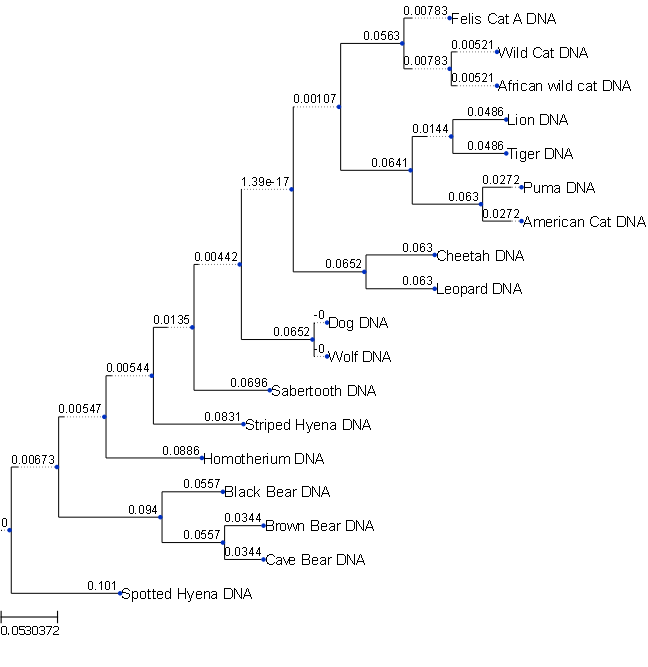

In [28]:
import os

fasta = "cat_dna.fasta"
dic = lire_fasta(fasta)
chiffre_vers_nom = list(dic.keys())
filename = "distmatrix.npy"

if os.path.isfile(filename):
    m = np.load(filename)
else:
    m = matrice_distance(dic)
    save_matrix(filename, m)

# Distance hyenes
def print_align(seq1, seq2):
    res = "["
    for e1, e2 in zip(seq1, seq2):
        if e1 == '-' or e2 == '-':
            res += '-'
        elif e1 != e2:
            res += 'S'
        else:
            res += ' '
    return res + "]"

h1 = "Striped Hyena DNA"
h2 = "Spotted Hyena DNA"
align = needleman_wunsch(dic[h1], dic[h2])
print("Alignement entre {} et {}".format(h1, h2))
print("{} : {}".format(h1, align[0]))
print("{} : {}".format(h2, align[1]))
print(print_align(*align))
    
#print(m)
newick = (upgma(m, chiffre_vers_nom))

t = Tree(newick)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 8 :** Quelles sont les hypothèses faites par UPGMA ? Semblent-elles respectées dans le cas présent ?

Réponse : L'hypothèse faite par UPGMA est que toutes les espèces de l'arbre évoluent à la même vitesse.
On trouve des résultats étranges, comme la hyène rayée plus éloignée de la hyène tachetée que de l'ours.

----
## Enracinement de l'arbre

Après avoir utilisé UPGMA pour réaliser votre arbre, l'enracinement s'est normalement fait au poids moyen. 

**Exercice 9 :** Quelle autre méthode est-il possible d'utiliser pour enraciner un arbre ? Pouvez-vous l'utilisez ici ? Si oui, afficher le nouvel arbre.

Réponse : 
- On peut utiliser l'enracinement par groupe extérieur. 
- Non, on ne peut pas l'utiliser ici.

----
## Neighbor-joining

Le neighbor-joining est un autre algorithme permettant de calculer un arbre phylogénique à partir d'une matrice de distance. Il a l'avantage de faire moins d'hypothèse qu'UPGMA sur les données (elles ne sont plus forcément ultramétrique) et il donne donc de meilleurs arbres dans presque tout les cas. Vous trouverez un example d'application de cet algorithme [ici](http://www.evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf).

**Exercice 10 :** Implémenter l'algorithme du neighbor-joining et appliquer-le aux données.

#### Données de tests unitaires

In [290]:
def before():
    return (np.array([
        [0, 5, 4, 7, 6, 8],
        [0, 0, 7, 10, 9, 11],
        [0, 0, 0, 7, 6, 8],
        [0, 0, 0, 0, 5, 9],
        [0, 0, 0, 0, 0, 8],
        [0, 0, 0, 0, 0, 0]
    ]
    ),
    [FeuilleNewick(i) for i in ["A", "B", "C", "D", "E", "F"]],
    ["A", "B", "C", "D", "E", "F"])

### 1. Calcul de Sx

In [269]:
def calculer_Sx(matrice, x):
    return (np.sum(matrice[x]) + np.sum(matrice[:,x])) / (np.size(matrice[0])-2)

def _test_calculer_sx():
    m, arbre, dic = before()
    
    assert calculer_Sx(m, 0) == 7.5
    assert calculer_Sx(m, 1) == 10.5
    assert calculer_Sx(m, 2) == 8
    assert calculer_Sx(m, 3) == 9.5
    assert calculer_Sx(m, 4) == 8.5
    assert calculer_Sx(m, 5) == 11
    
_test_calculer_sx()

### 2. Calcul de Mij

In [270]:
def get_Dab(matrice, i, j):
    """ Renvoie la valeur de la case i j sous la diagonale
        si la case donnée est située au dessus de la diagonale,
        i et j sont inversés.
        @param matrice
        @param i la ligne de la case
        @param j la colonne de la case
    """
    if i < j:
        i, j = j, i
    return matrice[i, j]

def calculer_Mij(matrice, i, j):
    return get_Dab(matrice, i, j) - calculer_Sx(matrice, i) - calculer_Sx(matrice, j)

def _test_calculer_mij():
    m, arbre, dic = before()
    
    assert calculer_Mij(m, 0, 1) == -13
    assert calculer_Mij(m, 3, 4) == -13
    
_test_calculer_mij()

AssertionError: 

### 3. Plus petit Mij

In [271]:
def plus_petit_Mij(matrice):
    """ Calcule la plus petite valeur Mij pour la matrice donnée.
        @param matrice la matrice dont on souhaite calculer le plus petit Mij
    """
    min = calculer_Mij(matrice, 0, 1)
    
    mini, minj = 0, 1
    for i in range(0, np.size(matrice[:,0])):
        for j in range(i+1, np.size(matrice[0])):
            mij = calculer_Mij(matrice, i, j)
            if min > mij:
                min = mij
                mini = i
                minj = j
                
    return mini, minj, min

### 4. Calcul de Sau

In [272]:
def calculer_sau(matrice, a, b):
    return get_Dab(matrice, a, b) / 2 + (calculer_Sx(matrice, a) - calculer_Sx(matrice, b)) / 2

def _test_calculer_sau():
    m, arbre, dic = before()
    
    assert calculer_sau(m, 0, 1) == 1
    assert calculer_sau(m, 1, 0) == 4
    
_test_calculer_sau()

AssertionError: 

### 5. Créer un noeud ab

In [277]:
def creer_noeud_ab(matrice, a, b, arbre):
    if b < a:
        c = a
        a = b
        b = c
    
    return NoeudNewick(arbre[a], calculer_sau(matrice, a, b), arbre[b], calculer_sau(matrice, b, a))

def _test_creer_noeud_ab():
    m, arbre, dic = before()
    
    n = creer_noeud_ab(m, 0, 1, arbre)
    assert n.distance_gauche == 1
    assert n.distance_droite == 4
    assert n.fils_gauche.toString() == "A"
    assert n.fils_droite.toString() == "B"
    
_test_creer_noeud_ab()

AssertionError: 

### 6. Neighbour joining

In [291]:
def cycle(matrice, arbre):
    i, j, min = plus_petit_Mij(matrice)
    n = creer_noeud_ab(matrice, i, j, arbre)
    arbre[i] = n
    del arbre[j]
    return i, j

def neighbor_joining(matrice, dic):
    
    # Bidictionnaire des groupes
    bidict = Bidict()
    for index, groupe in enumerate(dic):
        bidict[groupe] = index
    
    # Liste des noeuds de newick
    arbre = [FeuilleNewick(i) for i in dic]

    # Tant qu'il reste des groupes à fusionner
    while (len(arbre)) > 1:
        
        i, j = cycle(matrice, arbre)
        matrice = update_matrice(matrice, i, j, bidict, arbre)
    
    return arbre[0]

def _test_neighbor_joining():
    
    m, arbre, dic = before()
    
    print(neighbor_joining(m, dic))
_test_neighbor_joining()

IndexError: list index out of range

----
## Conclusion

**Exercice 11 :** Quelles sont vos conclusions par rapport à l'arbre phylogénique de _smilodon_, _homotherium_ et _M. trumani_ ? Comparer les deux méthodes. Comment expliquer les caractéristiques morphologiques similaires entre ces trois espèces ? Une réponse détaillée est attendue.

Réponse :